<a href="https://colab.research.google.com/github/AritraAmbudhDutta/BCS-Lluminating-Language/blob/main/Sentiment_Analysis_of_IMDB_Movie_Reviews_by_Aritra(230191)_W_O_Neuralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis of IMDB Movie Reviews**

**Import necessary libraries**

In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score, f1_score

import os
print(os.listdir("/content/sample_data"))
import warnings
warnings.filterwarnings('ignore')


['README.md', 'anscombe.json', 'california_housing_train.csv', 'mnist_test.csv', 'mnist_train_small.csv', 'california_housing_test.csv']


**Import the training dataset**

In [2]:
#importing the training data
imdb_data=pd.read_csv('/content/movie.csv')
print(imdb_data.shape)
imdb_data.head(10)

(40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


**Exploratery data analysis**

In [3]:
#Summary of the dataset
imdb_data.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


**Sentiment count**

In [4]:
#sentiment count
imdb_data['label'].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

Data is balanced. There is NO Value other than 0 or 1 in the sentiment column. Clearly NO missing entries as all 40000 entries we can see filled with 0 or 1.

In [5]:
#Checking for Duplicates
duplicate = imdb_data[imdb_data.duplicated()]

print("Duplicate Rows :")

# Print the resultant Dataframe
duplicate

Duplicate Rows :


,text,label
2164,"I find it rather useless to comment on this ""m...",0
3236,An absolutely atrocious adaptation of the wond...,0
3428,When I first saw this film it was not an impre...,0
3652,Before I watched this tv movie I did not know ...,1
3787,What a clunker!<br /><br />It MUST have been m...,0
...,...,...
39229,I Enjoyed Watching This Well Acted Movie Very ...,1
39246,You do realize that you've been watching the E...,0
39508,(Spoilers)<br /><br />Oh sure it's based on Mo...,0
39681,It's been a long time since I last saw a movie...,0


In [6]:
#Seems Like we have duplicate rows. Now time to delete them
imdb_data.drop_duplicates(inplace=True)
print(imdb_data)


                                                    text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[39723 rows x 2 columns]


In [7]:
#Checking for Duplicates again for assurance
duplicate = imdb_data[imdb_data.duplicated()]

print("Duplicate Rows :")

# Print the resultant Dataframe
duplicate

Duplicate Rows :


,text,label


No duplicate entries now!!!!

**Spliting the training dataset**

In [8]:
#split the dataset
#train dataset
train_reviews=imdb_data.text[:30000]
train_sentiments=imdb_data.label[:30000]
#test dataset
test_reviews=imdb_data.text[30000:]
test_sentiments=imdb_data.label[30000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(30000,) (30000,)
(9723,) (9723,)


**Text normalization**

# Data Pre-Processing

In [9]:
 #Importing stopwords from nltk library of Python
 import nltk
 nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords from nltk library
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Removing html strips and noise text**

In [10]:
#Removing the html strips from the text
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text by joining the two functions
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on text column in the dataframe
imdb_data['text']=imdb_data['text'].apply(denoise_text)


**Removing special characters**

In [11]:
#Define a function for removing special characters as it does not affect the text's sentiment
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on text column
imdb_data['text']=imdb_data['text'].apply(remove_special_characters)

**Text Stemming**

In [12]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on text column
imdb_data['text']=imdb_data['text'].apply(simple_stemmer)

**Removing stopwords**

In [13]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on text column
imdb_data['text']=imdb_data['text'].apply(remove_stopwords)

{"doesn't", 'ma', 'from', 'he', 'by', "couldn't", 'on', "mustn't", 'himself', 'very', 'them', 'should', 'why', 'do', 'to', 'too', 'nor', 'or', "you've", 'these', 'she', 'o', 'as', 'shan', 'during', 't', 'its', "haven't", 'those', "mightn't", 'you', 'couldn', 'ain', 'my', 'between', 'won', 's', 'no', 'the', 'had', 'are', 'his', 'her', 'will', "wasn't", 'and', 'if', 'this', 'further', 'herself', "isn't", 'ours', 'with', 'haven', 'him', 'same', 'here', 'into', 'did', 'can', 'where', 'their', 'up', 'wasn', 'being', 'y', 'other', 'a', 'such', "won't", 'that', 'any', 'for', 'more', "hasn't", "that'll", 'it', 've', 'yourselves', 'an', 'of', 'at', 'before', 'while', 'both', 'few', 'just', 'mustn', 'then', 'have', 'most', "shan't", "she's", 'below', 'each', 'mightn', "hadn't", 'd', 'but', 'once', 'who', 'doesn', 'themselves', 'after', 'there', 'does', 'myself', 'shouldn', "you'd", 'is', 'under', 'they', 'needn', "should've", 'down', "aren't", 'some', "didn't", 'i', 'through', 'above', 'whom', '

**Normalized train reviews**

In [14]:
#normalized train reviews
norm_train_reviews=imdb_data.text[:30000]
norm_train_reviews[0]

'grew b 1965 watch love thunderbird mate school watch play thunderbird befor school dure lunch school want virgil scott one want alan count 5 becam art form took children see movi hope would get glimps love child bitterli disappoint onli high point wa snappi theme tune could compar origin score thunderbird thank earli saturday morn one televis channel still play rerun seri gerri anderson hi wife creat jonatha frake hand hi director chair hi version wa complet hopeless wast film utter rubbish cgi remak may accept replac marionett homo sapien subsp sapien wa huge error judgment'

**Normalized test reviews**

In [15]:
#Normalized test reviews
norm_test_reviews=imdb_data.text[30000:]
norm_test_reviews[39228]

'wa excit discov thi wa avail couldnt wait see wast energi kind like rariti cd favorit band found back rack local music store hard core fan certain wa valuabl discoveri onc heard becam obviou whi dog never made onto real album thi dvd onli recommend completionist must everyth lynch ha done six men get sick somewhat visual interest short repetit lack power lynch later work grandmoth quit simpli immatur work tediou look like student film wa 70sit interest onli hope psychoanalyz director see briefli seed hi trademark imag sound alpahabet forgett realli cant rememb thi one ampute pointless cowboy frenchman plain silli lumier onli worthwhil one bunch without dialog lynch tell disturb tale compar hi best work watch thi one sever time run less 2 minut hardli worth troubl rent buy dvd'

# Feature Extraction

**Bags of words model**

It is used to convert text documents to numerical vectors or bag of words.

In [16]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (30000, 4871308)
BOW_cv_test: (9723, 4871308)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [17]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (30000, 4871308)
Tfidf_test: (9723, 4871308)


**Labeling the sentiment text**

In [18]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['label'])
print(sentiment_data.shape)

(39723, 1)


**Split the sentiment data**

In [19]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:30000]
test_sentiments=sentiment_data[30000:]
print(train_sentiments)
print(test_sentiments)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]


# Modelling the dataset and Evaluating the accuracy

# **Logistic Regression** model for both bag of words and tfidf features

In [20]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


**Logistic regression model performance on test dataset**

In [21]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 1 1 ... 0 1 1]
[0 1 1 ... 0 1 1]


**Accuracy of the model by Accuracy Score, F1 Score, ROC-AUC Score**

In [22]:
#Accuracy score for bag of words
lr_bow_accuracy_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_accuracy_score :",lr_bow_accuracy_score)
#Accuracy score for tfidf features
lr_tfidf_accuracy_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_accuracy_score :",lr_tfidf_accuracy_score)

#ROC_AUC score for bag of words
lr_bow_roc_auc_score=roc_auc_score(test_sentiments,lr_bow_predict)
print("lr_bow_roc_auc_score :",lr_bow_roc_auc_score)
#ROC_AUC score for tfidf features
lr_tfidf_roc_auc_score=roc_auc_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_roc_auc_score :",lr_tfidf_roc_auc_score)

#F1 score for bag of words
lr_bow_f1_score=f1_score(test_sentiments,lr_bow_predict)
print("lr_bow_f1_score :",lr_bow_f1_score)
#F1 score for tfidf features
lr_tfidf_f1_score=f1_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_f1_score :",lr_tfidf_f1_score)

lr_bow_accuracy_score : 0.7423634680654119
lr_tfidf_accuracy_score : 0.7423634680654119
lr_bow_roc_auc_score : 0.7423868085495346
lr_tfidf_roc_auc_score : 0.7424957343733337
lr_bow_f1_score : 0.7441527933816771
lr_tfidf_f1_score : 0.7418324229619706


**Print the classification report**

In [23]:
#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)
#Positive means 1 label and negative means 0 label

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74      4803
    Negative       0.75      0.74      0.74      4920

    accuracy                           0.74      9723
   macro avg       0.74      0.74      0.74      9723
weighted avg       0.74      0.74      0.74      9723

              precision    recall  f1-score   support

    Positive       0.73      0.75      0.74      4803
    Negative       0.75      0.73      0.74      4920

    accuracy                           0.74      9723
   macro avg       0.74      0.74      0.74      9723
weighted avg       0.74      0.74      0.74      9723



**Confusion matrix**

In [24]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3643 1277]
 [1228 3575]]
[[3599 1321]
 [1184 3619]]


# **Stochastic gradient descent or Linear Support Vector Machines(SVM) for bag of words and tfidf features**

In [25]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


**Model performance on test data**

In [26]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


**Accuracy of the model by Accuracy Score, F1 Score, ROC-AUC Score**

In [27]:
#Accuracy score for bag of words
svm_bow_accuracy_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_accuracy_score :",svm_bow_accuracy_score)
#Accuracy score for tfidf features
svm_tfidf_accuracy_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_accuracy_score :",svm_tfidf_accuracy_score)

#ROC_AUC score for bag of words
svm_bow_roc_auc_score=roc_auc_score(test_sentiments,svm_bow_predict)
print("svm_bow_roc_auc_score :",svm_bow_roc_auc_score)
#ROC_AUC score for tfidf features
svm_tfidf_roc_auc_score=roc_auc_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_roc_auc_score :",svm_tfidf_roc_auc_score)

#F1 score for bag of words
svm_bow_f1_score=f1_score(test_sentiments,svm_bow_predict)
print("svm_bow_f1_score :",svm_bow_f1_score)
#F1 score for tfidf features
svm_tfidf_f1_score=f1_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_f1_score :",svm_tfidf_f1_score)

svm_bow_accuracy_score : 0.6567931708320477
svm_tfidf_accuracy_score : 0.5072508485035483
svm_bow_roc_auc_score : 0.6532046155096154
svm_tfidf_roc_auc_score : 0.5012516948248807
svm_bow_f1_score : 0.7372234034175921
svm_tfidf_f1_score : 0.6724998291065691


**Print the classification report**

In [28]:
#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.88      0.35      0.51      4803
    Negative       0.60      0.95      0.74      4920

    accuracy                           0.66      9723
   macro avg       0.74      0.65      0.62      9723
weighted avg       0.74      0.66      0.62      9723

              precision    recall  f1-score   support

    Positive       0.93      0.00      0.01      4803
    Negative       0.51      1.00      0.67      4920

    accuracy                           0.51      9723
   macro avg       0.72      0.50      0.34      9723
weighted avg       0.72      0.51      0.34      9723



**Plot the confusion matrix**

In [29]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4681  239]
 [3098 1705]]
[[4919    1]
 [4790   13]]


# **Multinomial Naive Bayes for bag of words and tfidf features**

In [30]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


**Model performance on test data**

In [31]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 1 1 ... 0 1 1]
[0 1 1 ... 0 1 1]


**Accuracy of the model by Accuracy Score, F1 Score, ROC-AUC Score**

In [32]:
#Accuracy score for bag of words
mnb_bow_accuracy_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_accuracy_score :",mnb_bow_accuracy_score)
#Accuracy score for tfidf features
mnb_tfidf_accuracy_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_accuracy_score :",mnb_tfidf_accuracy_score)

#ROC_AUC score for bag of words
mnb_bow_roc_auc_score=roc_auc_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_roc_auc_score :",mnb_bow_roc_auc_score)
#ROC_AUC score for tfidf features
mnb_tfidf_roc_auc_score=roc_auc_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_roc_auc_score :",mnb_tfidf_roc_auc_score)

#F1 score for bag of words
mnb_bow_f1_score=f1_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_f1_score :",mnb_bow_f1_score)
#F1 score for tfidf features
mnb_tfidf_f1_score=f1_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_f1_score :",mnb_tfidf_f1_score)

mnb_bow_accuracy_score : 0.7429805615550756
mnb_tfidf_accuracy_score : 0.7428777126401317
mnb_bow_roc_auc_score : 0.7430832101887539
mnb_tfidf_roc_auc_score : 0.7430236691498708
mnb_bow_f1_score : 0.7430862547548062
mnb_tfidf_f1_score : 0.7420553033429633


**Print the classification report**

In [33]:
#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.73      0.75      0.74      4803
    Negative       0.75      0.73      0.74      4920

    accuracy                           0.74      9723
   macro avg       0.74      0.74      0.74      9723
weighted avg       0.74      0.74      0.74      9723

              precision    recall  f1-score   support

    Positive       0.73      0.76      0.74      4803
    Negative       0.75      0.73      0.74      4920

    accuracy                           0.74      9723
   macro avg       0.74      0.74      0.74      9723
weighted avg       0.74      0.74      0.74      9723



**Plot the confusion matrix**

In [34]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3614 1306]
 [1193 3610]]
[[3596 1324]
 [1176 3627]]


# **Random Forests for bag of words and tfidf features**

In [35]:
from sklearn.ensemble import RandomForestClassifier

#training the model
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
#fitting the svm for bag of words
rf_bow=rf.fit(cv_train_reviews,train_sentiments)
print(rf_bow)
#fitting the svm for tfidf features
rf_tfidf=rf.fit(tv_train_reviews,train_sentiments)
print(rf_tfidf)

RandomForestClassifier(max_depth=5)
RandomForestClassifier(max_depth=5)


**Model performance on test data**

In [36]:
#Predicting the model for bag of words
rf_bow_predict=rf.predict(cv_test_reviews)
print(rf_bow_predict)
#Predicting the model for tfidf features
rf_tfidf_predict=rf.predict(tv_test_reviews)
print(rf_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


**Accuracy of the model by Accuracy Score, F1 Score, ROC-AUC Score**

In [37]:
#Accuracy score for bag of words
rf_bow_accuracy_score=accuracy_score(test_sentiments,rf_bow_predict)
print("rf_bow_accuracy_score :",rf_bow_accuracy_score)
#Accuracy score for tfidf features
rf_tfidf_accuracy_score=accuracy_score(test_sentiments,rf_tfidf_predict)
print("rf_tfidf_accuracy_score :",rf_tfidf_accuracy_score)

#ROC_AUC score for bag of words
rf_bow_roc_auc_score=roc_auc_score(test_sentiments,rf_bow_predict)
print("rf_bow_roc_auc_score :",rf_bow_roc_auc_score)
#ROC_AUC score for tfidf features
rf_tfidf_roc_auc_score=roc_auc_score(test_sentiments,rf_tfidf_predict)
print("rf_tfidf_roc_auc_score :",rf_tfidf_roc_auc_score)

#F1 score for bag of words
rf_bow_f1_score=f1_score(test_sentiments,rf_bow_predict)
print("rf_bow_f1_score :",rf_bow_f1_score)
#F1 score for tfidf features
rf_tfidf_f1_score=f1_score(test_sentiments,rf_tfidf_predict)
print("rf_tfidf_f1_score :",rf_tfidf_f1_score)

rf_bow_accuracy_score : 0.49388048956083513
rf_tfidf_accuracy_score : 0.49388048956083513
rf_bow_roc_auc_score : 0.49988352046231266
rf_tfidf_roc_auc_score : 0.49988352046231266
rf_bow_f1_score : 0.0020279862096937743
rf_tfidf_f1_score : 0.0020279862096937743


**Print the classification report**

In [38]:
#Classification report for bag of words
rf_bow_report=classification_report(test_sentiments,rf_bow_predict,target_names=['Positive','Negative'])
print(rf_bow_report)
#Classification report for tfidf features
rf_tfidf_report=classification_report(test_sentiments,rf_tfidf_predict,target_names=['Positive','Negative'])
print(rf_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.49      1.00      0.66      4803
    Negative       0.45      0.00      0.00      4920

    accuracy                           0.49      9723
   macro avg       0.47      0.50      0.33      9723
weighted avg       0.47      0.49      0.33      9723

              precision    recall  f1-score   support

    Positive       0.49      1.00      0.66      4803
    Negative       0.45      0.00      0.00      4920

    accuracy                           0.49      9723
   macro avg       0.47      0.50      0.33      9723
weighted avg       0.47      0.49      0.33      9723



**Plot the confusion matrix**

In [39]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,rf_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,rf_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[   5 4915]
 [   6 4797]]
[[   5 4915]
 [   6 4797]]


**Conclusion:**
* We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector  machines.

# **Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

<function matplotlib.pyplot.show(close=None, block=None)>

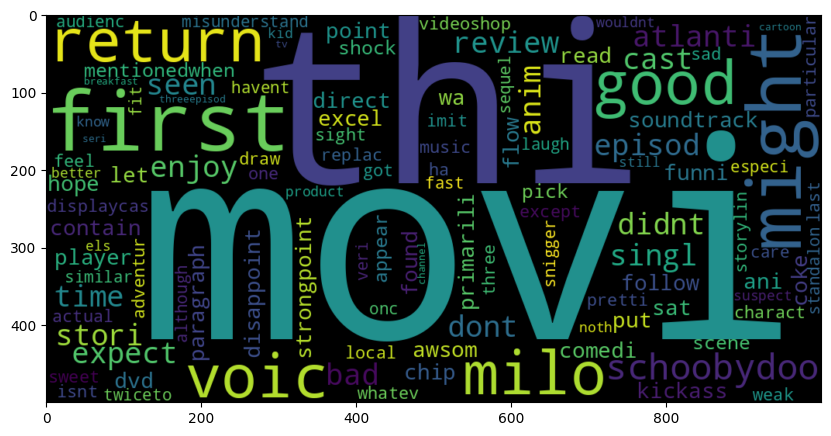

In [40]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for negative review words**

<function matplotlib.pyplot.show(close=None, block=None)>

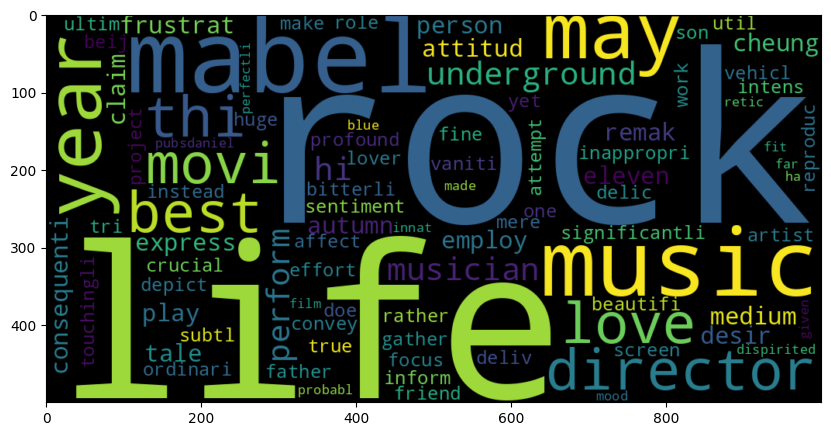

In [41]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

# References:
[Some Kaggle Notebooks](https://www.kaggle.com/),
[Medium Articles](https://www.medium.com),
[GfG Articles](https://www.geeksforgeeks.org/),
Google Search
